In [1]:
!pip install dgl

In [2]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Embedding, Input, Conv1D, Add, Activation, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [4]:
# Set parameters to see all data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [5]:
# Load data from a list of files.
def load_data(files):
    data_list = []
    for file in files:
        with open(file, 'rb') as f:
            data = np.load(f)
            data_list.append(data)
    return data_list


In [6]:
# Prepare data for training by combining positive and negative sequences,
# creating labels, and splitting into training and testing sets.
def prepare_data(pos_sequences, neg_sequences):
    pos_labels = np.ones(len(pos_sequences))
    neg_labels = np.zeros(len(neg_sequences))
    X = np.concatenate([pos_sequences, neg_sequences])
    y = np.concatenate([pos_labels, neg_labels])
    return train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)



In [7]:
### Build and compile a 5 layer LSTM model.

## Parameters:
## input_shape (tuple): Shape of the input data (timesteps, features).
## lstm_units (int): Number of units in the LSTM layers.
## dropout_rate (float): Dropout rate for the Dropout layers (default is 0.2).

## Returns: model: Compiled LSTM model.

def build_lstm_model(input_shape, lstm_units, dropout_rate=0.2):
    model = Sequential([
        LSTM(lstm_units, input_shape=input_shape, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [8]:
def build_resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    # Apply the first convolutional layer
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    # Apply batch normalization to the output of the convolutional layer
    x = BatchNormalization()(x)
    # Apply ReLU activation function
    x = Activation('relu')(x)

    # Apply the second convolutional layer
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    # Apply batch normalization to the output of the second convolutional layer
    x = BatchNormalization()(x)

    # Add the input tensor to the output of the second batch normalization (skip connection)
    x = Add()([x, input_tensor])
    # Apply ReLU activation function again
    x = Activation('relu')(x)

    # Return the output tensor
    return x


In [9]:
### Build and compile a resnet model.

def build_resnet_model(input_shape, num_blocks=4):
    # Define the input layer with the given shape
    inputs = Input(shape=input_shape)

    # Apply the initial convolutional layer
    x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    # Apply batch normalization to the output of the initial convolutional layer
    x = BatchNormalization()(x)

    # Add residual blocks to the model
    for _ in range(num_blocks):
        x = build_resnet_block(x, 64)

    # Flatten the output of the residual blocks
    x = Flatten()(x)

    # Add a dense layer with a sigmoid activation function
    x = Dense(1, activation='sigmoid')(x)

    # Create the model with the specified input and output
    model = Model(inputs, x)

    # Compile the model with the Adam optimizer and binary cross-entropy loss
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Return the compiled model
    return model


In [10]:
## Create confusion matrix and plots for evaluate model

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):

    # Compute the confusion matrix using the true and predicted labels
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()



In [11]:
## Display classification accuracy report

def print_classification_report(y_true, y_pred):
    print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_pred) * 100))
    print("Classification Report:\n", classification_report(y_true, y_pred))


In [12]:
def evaluate_model(model, X_test, y_test, thresholds=[0.5]):
    # Predict the probabilities for the test data using the model
    y_pred_probs = model.predict(X_test)

    # Initialize an empty dictionary to store the results for different thresholds
    results = {}

    # Iterate over each threshold to evaluate the model
    for threshold in thresholds:
        # Convert the predicted probabilities to binary predictions based on the threshold
        y_pred = (y_pred_probs > threshold).astype('int32')

        # Calculate the accuracy of the predictions
        accuracy = accuracy_score(y_test, y_pred)

        # Store the accuracy and classification report in the results dictionary
        results[threshold] = {
            'accuracy': accuracy,
            'report': classification_report(y_test, y_pred, output_dict=True)
        }

        # Print the threshold and corresponding accuracy
        print(f"Threshold: {threshold}, Accuracy: {accuracy:.2f}")

        # Plot the confusion matrix for the current threshold
        plot_confusion_matrix(y_test, y_pred, title=f'Confusion Matrix (Threshold: {threshold})')

        # Display evaluate metrics
        print("Accuracy Ratio: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
        print("Classification Report:\n", classification_report(y_test, y_pred))

    # Return the results dictionary containing accuracy and classification reports for each threshold
    return results


In [13]:
# Define files
files = ['neg_sequences.npy', 'pos_sequences.npy']

# Load data
data_list = load_data(files)
for data in data_list:
    print(data)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ...

In [14]:
## Label data
pos_sequences = data_list[0]
neg_sequences = data_list[1]

In [15]:
# Prepare data
X_train, X_test, y_train, y_test = prepare_data(pos_sequences, neg_sequences)


In [16]:
print('Positive case shape : ', pos_sequences.shape)
print('Negative case shape : ', neg_sequences.shape)

Positive case shape :  (100000, 10, 312)
Negative case shape :  (11979, 10, 312)


In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89583, 10, 312), (22396, 10, 312), (89583,), (22396,))

## LSTM Model

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs
Epoch 1/10
2800/2800 [==============================] - 181s 56ms/step - loss: 0.2750 - accuracy: 0.8983 - val_loss: 0.2294 - val_accuracy: 0.9101
Epoch 2/10
2800/2800 [==============================] - 147s 53ms/step - loss: 0.2386 - accuracy: 0.9055 - val_loss: 0.2227 - val_accuracy: 0.9127
Epoch 3/10
2800/2800 [==============================] - 147s 52ms/step - loss: 0.2322 - accuracy: 0.9084 - val_loss: 0.2209 - val_accuracy: 0.9140
Epoch 4/10
2800/2800 [==============================] - 151s 54ms/step - loss: 0.2281 - accuracy: 0.9096 - val_loss: 0.2230 - val_accuracy: 0.9100
Epoch 5/10
2800/2800 [==============================] - 149s 53ms/step - loss: 0.2260 - accuracy: 0.9109 - val_loss: 0.2216 - val_accuracy: 0.9147
Epoch 6/10
2800/2800 [==============================] - 143s 51ms/step - loss: 0.2233 - accuracy: 0.9118 - val_loss: 0.2215 - val_accuracy: 0.9111
Epoch 7/10
2800/2800 [==============================] 

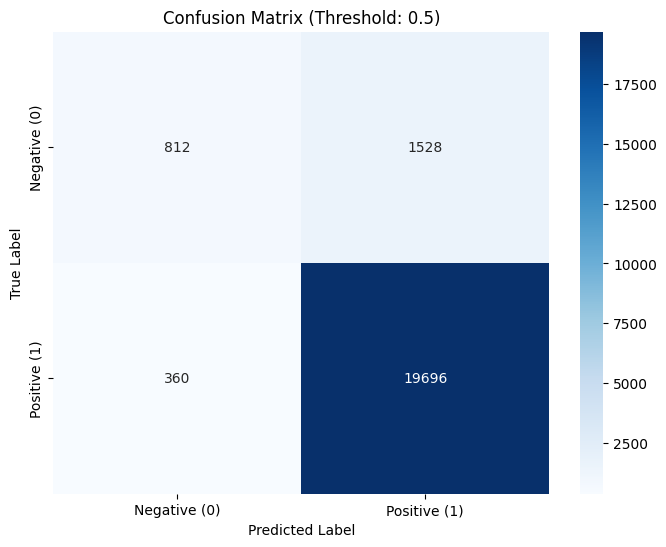

Accuracy Ratio: 91.57%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.35      0.46      2340
         1.0       0.93      0.98      0.95     20056

    accuracy                           0.92     22396
   macro avg       0.81      0.66      0.71     22396
weighted avg       0.90      0.92      0.90     22396



In [18]:
%time
# Train and evaluate LSTM model

input_shape = (10, 312)
lstm_model = build_lstm_model(input_shape, lstm_units=50)
lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
lstm_results = evaluate_model(lstm_model, X_test, y_test)


In [19]:
# Make prediction
lstm_y_prob = lstm_model.predict(X_test)
y_pred = (lstm_y_prob > 0.5).astype('int32')  # To classify, using 0.5 as a threshold


700/700 [==============================] - 7s 9ms/step


In [20]:
## Create result dataframe

result_df = pd.DataFrame()
result_df['actual'] = y_test.astype(int)
result_df['ltsm_prob'] = lstm_y_prob
result_df['ltsm_pred'] = y_pred

result_df.head()

,actual,ltsm_prob,ltsm_pred
0,1,0.996721,1
1,1,0.849515,1
2,1,0.235680,0
3,0,0.600664,1
4,1,0.996346,1


## Resnet Model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs
Epoch 1/10
2800/2800 [==============================] - 64s 20ms/step - loss: 0.2547 - accuracy: 0.9027 - val_loss: 0.2456 - val_accuracy: 0.8997
Epoch 2/10
2800/2800 [==============================] - 57s 20ms/step - loss: 0.2236 - accuracy: 0.9121 - val_loss: 0.2229 - val_accuracy: 0.9131
Epoch 3/10
2800/2800 [==============================] - 56s 20ms/step - loss: 0.2148 - accuracy: 0.9153 - val_loss: 0.2243 - val_accuracy: 0.9111
Epoch 4/10
2800/2800 [==============================] - 56s 20ms/step - loss: 0.2054 - accuracy: 0.9176 - val_loss: 0.2313 - val_accuracy: 0.9119
Epoch 5/10
2800/2800 [==============================] - 58s 21ms/step - loss: 0.1953 - accuracy: 0.9218 - val_loss: 0.2346 - val_accuracy: 0.9099
Epoch 6/10
2800/2800 [==============================] - 58s 21ms/step - loss: 0.1846 - accuracy: 0.9265 - val_loss: 0.2441 - val_accuracy: 0.9078
Epoch 7/10
2800/2800 [==============================] - 58s 2

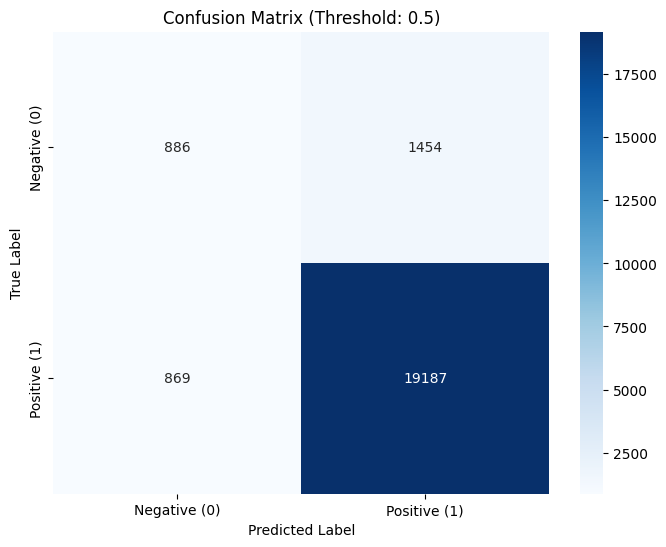

Accuracy Ratio: 89.63%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.38      0.43      2340
         1.0       0.93      0.96      0.94     20056

    accuracy                           0.90     22396
   macro avg       0.72      0.67      0.69     22396
weighted avg       0.89      0.90      0.89     22396



In [21]:
%time

# Train and evaluate ResNet model
resnet_model = build_resnet_model(input_shape)
resnet_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
resnet_results = evaluate_model(resnet_model, X_test, y_test)

In [22]:
# Make prediction and accorfing to the threshold, classify the probability
threshold = 0.5
y_resnet_prob = resnet_model.predict(X_test)
result_df['resnet_prob'] = y_resnet_prob
result_df[f'resnet_pred'] = result_df['resnet_prob'].apply(lambda x: 1 if x > threshold else 0)


700/700 [==============================] - 4s 6ms/step


In [23]:
result_df.head()

,actual,ltsm_prob,ltsm_pred,resnet_prob,resnet_pred
0,1,0.996721,1,0.999517,1
1,1,0.849515,1,0.735970,1
2,1,0.235680,0,0.805859,1
3,0,0.600664,1,0.994927,1
4,1,0.996346,1,0.998894,1


## Graph Neural Network

In [24]:
## Label data
pos_labels = np.ones(len(pos_sequences))
neg_labels = np.zeros(len(neg_sequences))

Epoch 1/10, Loss: 0.6844635605812073
Epoch 2/10, Loss: 0.4763614237308502
Epoch 3/10, Loss: 0.3407481908798218
Epoch 4/10, Loss: 0.34609049558639526
Epoch 5/10, Loss: 0.3649972975254059
Epoch 6/10, Loss: 0.3419504761695862
Epoch 7/10, Loss: 0.3056755065917969
Epoch 8/10, Loss: 0.28020524978637695
Epoch 9/10, Loss: 0.2724938988685608
Epoch 10/10, Loss: 0.27580976486206055


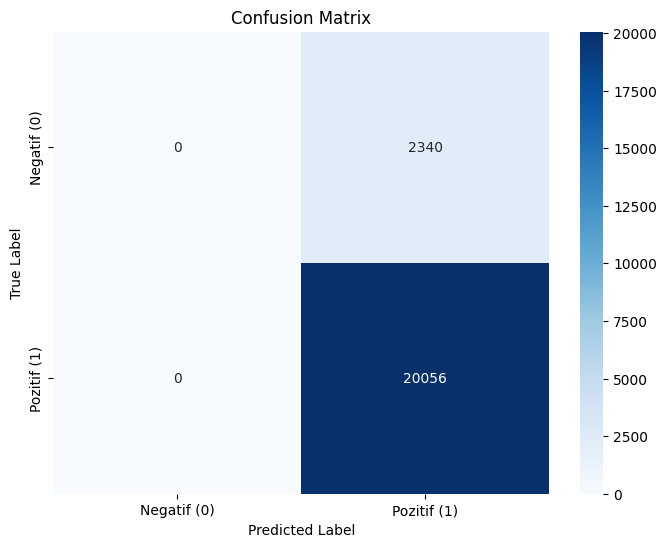

Accuracy: 89.55%
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2340
           1       0.90      1.00      0.94     20056

    accuracy                           0.90     22396
   macro avg       0.45      0.50      0.47     22396
weighted avg       0.80      0.90      0.85     22396

CPU times: user 21.6 s, sys: 18.2 s, total: 39.7 s
Wall time: 39.2 s


In [25]:
%%time
# Concatenate features and labels
X = np.concatenate([pos_sequences, neg_sequences])
X = X.reshape((X.shape[0], -1))  # Flatten the sequences if necessary
y = np.concatenate([pos_labels, neg_labels])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create graphs
def build_graph(X, y):
    edge_index = torch.tensor([[], []], dtype=torch.long)  # No edges in this example
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

train_data = build_graph(X_train, y_train)
test_data = build_graph(X_test, y_test)

# Create DataLoader
train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
test_loader = DataLoader([test_data], batch_size=32, shuffle=False)

# Define GCN model
class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Create model
in_channels = X_train.shape[1]
hidden_channels = 50
out_channels = 2
model = GCNModel(in_channels, hidden_channels, out_channels)

# Prepare model for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

# Train model
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

# Make predictions on test set
model.eval()
y_gnn_pred_probs = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        out = model(data)
        y_gnn_pred_probs.append(torch.exp(out)[:, 1].cpu().numpy())  # Probabilities
        y_true.append(data.y.cpu().numpy())

y_gnn_pred_probs = np.concatenate(y_gnn_pred_probs)
y_true = np.concatenate(y_true)
y_gnn_pred = (y_gnn_pred_probs > 0.5).astype('int32')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_gnn_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif (0)', 'Pozitif (1)'], yticklabels=['Negatif (0)', 'Pozitif (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print other performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_true, y_gnn_pred) * 100))
print("Classification Report:\n", classification_report(y_true, y_gnn_pred))



In [59]:
# Assign the predicted probabilities from the GNN model to a new column 'gnn_prob' in the result dataframe
result_df['gnn_prob'] = y_gnn_pred_probs

# Create a new column 'gnn_preb' by applying a lambda function that assigns a binary value based on the threshold
# If the probability is greater than the threshold, it assigns 1, otherwise it assigns 0
result_df[f'gnn_preb'] = result_df['gnn_prob'].apply(lambda x: 1 if x > 0.75 else 0)

# Display the first few rows of the result dataframe
result_df.head()


,actual,ltsm_prob,ltsm_pred,resnet_prob,resnet_pred,gnn_prob,gnn_preb
0,1,0.996721,1,0.999517,1,0.970252,1
1,1,0.849515,1,0.735970,1,0.839069,1
2,1,0.235680,0,0.805859,1,0.575894,0
3,0,0.600664,1,0.994927,1,0.671006,0
4,1,0.996346,1,0.998894,1,0.924221,1


In [60]:
# Print the number of rows where 'actual' value is 1 in result_df
print('Total positive case number : ', result_df[result_df['actual'] == 1].shape[0])

# Print the number of rows where 'actual' value is 1 and 'ltsm_pred' value is 1 in result_df
print('LSTM true positive case number : ', result_df[(result_df['actual'] == 1) & (result_df['ltsm_pred'] == 1)].shape[0])

# Print the number of rows where 'actual' value is 1 and 'resnet_pred' value is 1 in result_df
print('RESNET true positive case number : ', result_df[(result_df['actual'] == 1) & (result_df['resnet_pred'] == 1)].shape[0])

# Print the number of rows where 'actual' value is 1 and 'gnn_preb' value is 1 in result_df
print('GNN true positive case number : ', result_df[(result_df['actual'] == 1) & (result_df['gnn_preb'] == 1)].shape[0])


Total positive case number :  20056
LSTM true positive case number :  19696
RESNET true positive case number :  19187
GNN true positive case number :  17545


In [61]:
## Export results as csv
result_df.to_csv('results.csv', index=False)


In [62]:
result_df.head()

,actual,ltsm_prob,ltsm_pred,resnet_prob,resnet_pred,gnn_prob,gnn_preb
0,1,0.996721,1,0.999517,1,0.970252,1
1,1,0.849515,1,0.735970,1,0.839069,1
2,1,0.235680,0,0.805859,1,0.575894,0
3,0,0.600664,1,0.994927,1,0.671006,0
4,1,0.996346,1,0.998894,1,0.924221,1


In [63]:
# Print the number of rows where 'actual' value is 1 in result_df
print('Total case number : ', result_df.shape[0])

# Print the number of rows where 'actual' value is 1 in result_df
print('Total positive case number : ', result_df[result_df['actual'] == 1].shape[0])

# Print the number of rows where 'actual' value is 0 and 'gnn_preb' value is 0 in result_df
print('GNN true negative case number : ', result_df[(result_df['actual'] == 0) & (result_df['gnn_preb'] == 0)].shape[0])

# Print the number of rows where 'actual' value is 0 and 'gnn_preb' value is 1 in result_df
print('GNN false negative case number : ', result_df[(result_df['actual'] == 0) & (result_df['gnn_preb'] == 1)].shape[0])

# Print the number of rows where 'actual' value is 1 and 'gnn_preb' value is 0 in result_df
print('GNN false positive case number : ', result_df[(result_df['actual'] == 1) & (result_df['gnn_preb'] == 0)].shape[0])

# Print the number of rows where 'actual' value is 1 and 'gnn_preb' value is 1 in result_df
print('GNN true positive case number : ', result_df[(result_df['actual'] == 1) & (result_df['gnn_preb'] == 1)].shape[0])


Total case number :  22396
Total positive case number :  20056
GNN true negative case number :  1352
GNN false negative case number :  988
GNN false positive case number :  2511
GNN true positive case number :  17545


In [64]:
result_df.head(10)

,actual,ltsm_prob,ltsm_pred,resnet_prob,resnet_pred,gnn_prob,gnn_preb
0,1,0.996721,1,0.999517,1,0.970252,1
1,1,0.849515,1,0.735970,1,0.839069,1
2,1,0.235680,0,0.805859,1,0.575894,0
3,0,0.600664,1,0.994927,1,0.671006,0
4,1,0.996346,1,0.998894,1,0.924221,1
5,1,0.995251,1,0.998192,1,0.788198,1
6,1,0.996997,1,0.999999,1,0.911786,1
7,1,0.947724,1,0.996547,1,0.589092,0
8,1,0.996375,1,0.991584,1,0.947996,1
9,1,0.997677,1,0.999993,1,0.874716,1


In [65]:
result_df[result_df['actual'] == 0].head(10)

,actual,ltsm_prob,ltsm_pred,resnet_prob,resnet_pred,gnn_prob,gnn_preb
3,0,0.600664,1,0.994927,1,0.671006,0
13,0,0.849566,1,0.964356,1,0.834844,1
19,0,0.495369,0,0.311143,0,0.737196,0
24,0,0.729246,1,0.625211,1,0.781840,1
39,0,0.684110,1,0.321514,0,0.734444,0
41,0,0.711010,1,0.154962,0,0.713135,0
42,0,0.381123,0,0.328051,0,0.602260,0
44,0,0.461208,0,0.448851,0,0.611314,0
51,0,0.184057,0,0.078547,0,0.575486,0
59,0,0.823827,1,0.967498,1,0.862028,1
